On this notebook I take a look at the first labeled images we obtained from the sumatra photos. I also test two feature extraction methods: HoG and Inception v3 net (pre-trained on imagenet) by using them to perform a simple classification.

In [17]:
import os
import shutil
import numpy as np
import scipy.ndimage as img

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import data, io, filters
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import hog
import skimage

from models.invariants import compute_invariants

## Reading images
We start by reading image files.

In [18]:
path = "Data/fotos_sumatra/"
dirs = os.listdir(path)
bad = [e for e in dirs if e.find('AVEC') > -1][0]
good = [e for e in dirs if e.find('SANS') > -1][0]
bad = os.path.join(path, bad)
good = os.path.join(path, good)
bad = [os.path.join(bad, f) for f in os.listdir(bad)]
good = [os.path.join(good, f) for f in os.listdir(good)]

In [19]:
bad,good

(['Data/fotos_sumatra/empreinte piste ext-AVEC/1',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/10',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/100',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/106 def1',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/106 def2',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/11',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/114',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/116',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/13',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/16',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/2',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/22',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/23',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/25',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/31',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/32',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/36',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/38',
  'Data/fotos_sumatra/empreinte piste ext-AVEC/39',

For this first experiment, we have only a few images of a specifica type of defect.

In [20]:
print("defect: ", len(bad), ", non defect", len(good))

defect:  35 , non defect 34


In [21]:
bad_files = bad
good_files = good
bad = [io.imread(f) for f in bad]
good = [io.imread(f) for f in good]

We wil consider a square patch in the center of the image. Here we crop and resize so they all have 224 x 224 pixels.

In [22]:
def crop_resize(image, size=224):
    height, width, ch = image.shape
    ratio = image.shape[0]/image.shape[1] 
    if ratio > 1.0:
        ratio = 1.0/ratio
    if ratio < 0.9:
        offset = np.abs(width-height)//2
        if height < width:
            image = image[:,offset:-offset, :]
        else:
            image = image[offset:-offset, :, :]
    image = skimage.transform.resize(image, (size, size, ch))
    return image
good = list(map(crop_resize, good))
bad = list(map(crop_resize, bad))

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Taking a look
Let's see how the images look like.

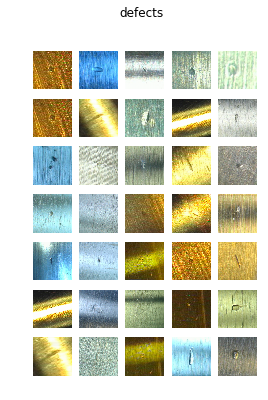

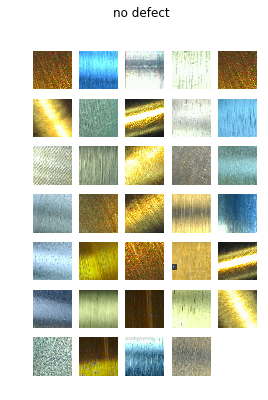

In [23]:
def show_images(images):
    width=5
    height = int(np.ceil(len(images)/5))
    for i, img in enumerate(images):
        plt.subplot(height, width, i+1)
        plt.imshow(img)
        plt.axis('off')

plt.figure(figsize=(4,6))
plt.suptitle('defects')
show_images(bad)

plt.figure(figsize=(4,6))
plt.suptitle('no defect')
show_images(good)



## Equalization
The metalic surface yields homogeneus texture but strong reflexes. 
Here I test some different equalizations over different color spaces to improve sailiency of the defect.

In [24]:
matplotlib.rcParams['font.size'] = 9

def as_gray(image_filter, image, *args, **kwargs):
    gray_image = rgb2gray(image)
    return image_filter(gray_image, *args, **kwargs)

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    if image.ndim == 3:
        ax_img.imshow(image)
    else:
        ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


def test_different_equalizations(image):
    # Load an example image
    img = img_as_ubyte(image)

    # Global equalize
    img_rescale = exposure.equalize_hist(img)

    # Equalization
    selem = disk(60)
    img_eq = rank.equalize(img, selem=selem)
    return image, img_rescale, img_eq

def display_equalization(img, img_rescale, img_eq):
    # Display results
    fig = plt.figure(figsize=(8, 5))
    axes = np.zeros((2, 3), dtype=np.object)
    axes[0, 0] = plt.subplot(2, 3, 1, adjustable='box-forced')
    axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0],
                             adjustable='box-forced')
    axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0],
                             adjustable='box-forced')
    axes[1, 0] = plt.subplot(2, 3, 4)
    axes[1, 1] = plt.subplot(2, 3, 5)
    axes[1, 2] = plt.subplot(2, 3, 6)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
    ax_img.set_title('Low contrast image')
    ax_hist.set_ylabel('Number of pixels')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
    ax_img.set_title('Global equalize')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
    ax_img.set_title('Local equalize')
    ax_cdf.set_ylabel('Fraction of total intensity')


    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

In [25]:
def based_on_hsv(image):
    image = rgb2hsv(image)[:,:,-1]
    return test_different_equalizations(image)

def based_on_rgb(image):
    res = 3*[np.zeros_like(image)]
    for i in range(3):
        out = test_different_equalizations(image[:,:,i])
        for j, o in enumerate(out):
            res[j][:,:,i] = o
    return tuple(res)
@adapt_rgb(as_gray)
def based_on_gray(image):
    return test_different_equalizations(image)

Here we pick a sample image.

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


(-0.5, 223.5, 223.5, -0.5)

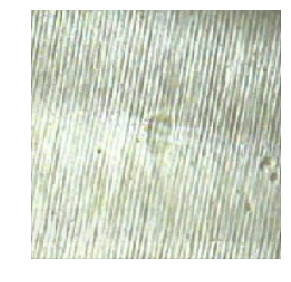

In [26]:
image = bad[11]
io.imshow(image)
plt.axis("off")

### testing equalization over v channel on HSV color space

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


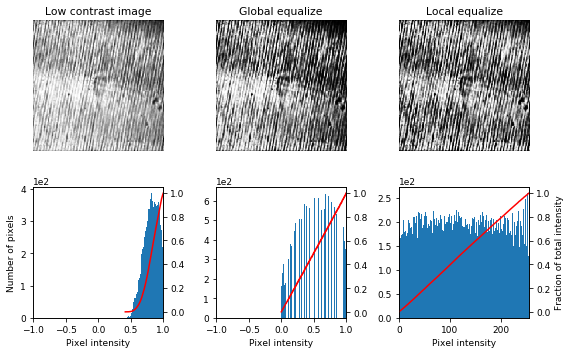

In [27]:
display_equalization(*based_on_hsv(image))

### testing equalization over grayscale image

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


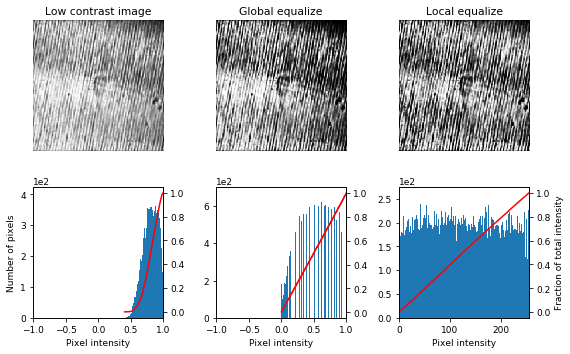

In [28]:
display_equalization(*based_on_gray(image))

### testing equalization over each RGB channel independently

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


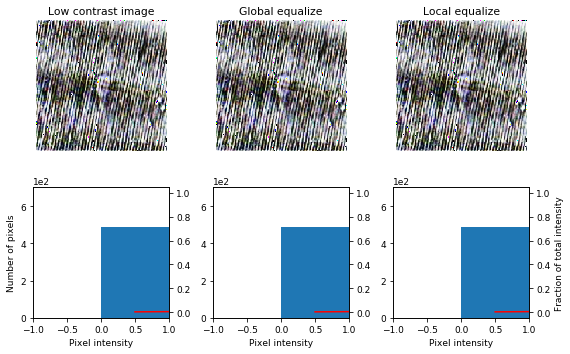

In [29]:
res = based_on_rgb(image)
display_equalization(*res)

## Tests: feature extraction + logistic regression

In [53]:
from tqdm import tqdm

def feature_xtract(feature_fn):
    global good, bad
    images = good + bad
    X = [feature_fn(img) for img in tqdm(images, desc='feature xtrac')]
    #X = np.array(X)
    return X

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

def classify(X, random_state=0):
    global good, bad
    y = np.array([0]*len(good) + [1]*len(bad))

    pipeline = Pipeline([
        #('normalize', MinMaxScaler()),
         ('classify', LogisticRegression())])
    params = [{'classify__C': np.logspace(-4,4,10)}]
    
    acc=[]
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)  
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = GridSearchCV(pipeline,params, cv=skf)
        model.fit(X_train,y_train)
#         model.scores_[1].shape
#         print("regulariz. ", " ".join(["cv-%d " %i for i in range(5)]))
#         for i, line in enumerate(model.scores_[1].T):
#             print("%0.4e" % model.Cs_[i], (" %0.2f "*5) % tuple(line))
#         model.scores_[1].mean(axis=0).T
        acc.append(model.score(X_test, y_test))
        print("accuracy on test", model.score(X_test, y_test))
    print("average test accuracy", np.mean(acc), np.std(acc))
    return model

### Test 1: HSV-V  + HoG descriptor
Here I use HoG features over HSV-V channel with global image normalization (parameter transform_sqrt).

In [96]:
def hog_feature(image):
    # get hsv V value
    image = rgb2hsv(image)[:,:,-1]
    fd, imgd = hog(image, orientations=8, pixels_per_cell=(32, 32), transform_sqrt=True,
            cells_per_block=(1, 1), visualise=True)
    return fd, imgd


In [97]:
X_hog = feature_xtract(hog_feature)
X_hog_img = np.stack([feat[1] for feat in X_hog])
X_hog = np.stack([feat[0] for feat in X_hog])



feature xtrac:   0%|          | 0/69 [00:00<?, ?it/s]/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


feature xtrac:   7%|▋         | 5/69 [00:00<00:01, 44.27it/s]

feature xtrac:  14%|█▍        | 10/69 [00:00<00:01, 46.46it/s]

feature xtrac:  22%|██▏       | 15/69 [00:00<00:01, 46.97it/s]

feature xtrac:  29%|██▉       | 20/69 [00:00<00:01, 47.15it/s]

feature xtrac:  36%|███▌      | 25/69 [00:00<00:00, 47.50it/s]

feature xtrac:  43%|████▎     | 30/69 [00:00<00:00, 47.69it/s]

feature xtrac:  51%|█████     | 35/69 [00:00<00:00, 47.72it/s]

feature xtrac:  59%|█████▉    | 41/69 [00:00<00:00, 48.15it/s]

feature xtrac:  67%|██████▋   | 46/69 [00:00<00:00, 47.79it/s]

feature xtrac:  74%|███████▍  | 51/69 [00:01<00:00, 47.67it/s]

feature xtrac:  81%|████████  | 56/69 [00:01<00:00, 47.74

In [98]:
y = np.array([0]*len(good) + [1]*len(bad))

TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=0, verbose=0)

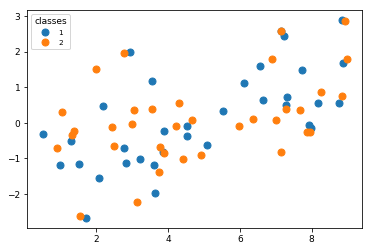

In [99]:
%run prototype_plots.py
plot2D(X_hog, y, method='tsne', N=2, random_state=0)

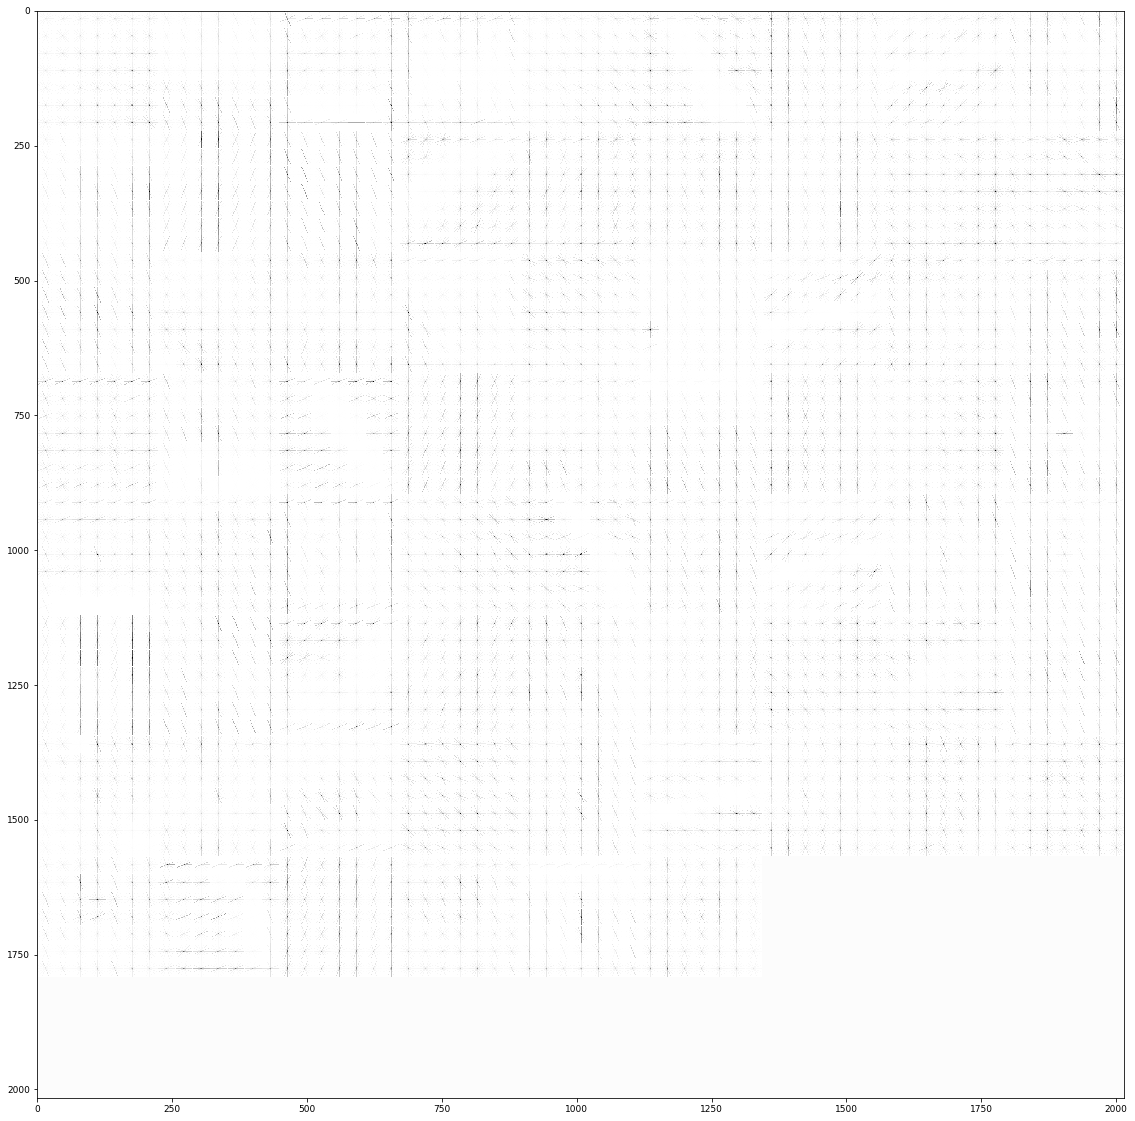

In [100]:
plt.imshow(skimage.util.montage.montage2d(X_hog_img,rescale_intensity=True), cmap='Greys')
plt.gcf().set_size_inches(20,20)

In [113]:
classify(X_hog)

/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


accuracy on test 0.5
accuracy on test 0.42857142857142855


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


accuracy on test 0.42857142857142855
accuracy on test 0.6428571428571429
accuracy on test 0.6153846153846154
average test accuracy 0.5230769230769231 0.09084396784808962


/mnt/Data/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:715: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid=[{'classify__C': array([1.00000e-04, 7.74264e-04, 5.99484e-03, 4.64159e-02, 3.59381e-01,
       2.78256e+00, 2.15443e+01, 1.66810e+02, 1.29155e+03, 1.00000e+04])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

### Test 2: Inception V3 features (over RGB)

In [44]:
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from keras.preprocessing import image
from keras.models import Model
import numpy as np

def inceptionV3_feature(img):
    base_model = InceptionV3(weights='imagenet', include_top=False)
    x = base_model.output
    # add a global spatial average pooling layer
    x = GlobalAveragePooling2D()(x)
    model = Model(inputs=base_model.input, outputs=x
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    features = model.predict(x)
    return features.flatten()

In [17]:
X_inceptionV3 = feature_xtract(inceptionV3_feature)

feature xtrac: 100%|██████████| 69/69 [21:52<00:00, 19.02s/it]


['empreinte piste ext-AVEC',
 'empreinte piste ext-SANS',
 'features_inceptionV3.npy',
 'images_inceptionV3.npy',
 'images_inceptionV3.txt']

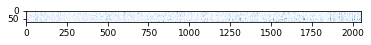

In [50]:
np.save(os.path.join(path,'features_inceptionV3.npy'), X_inceptionV3)
np.savetxt(os.path.join(path,'images_inceptionV3.txt'), good_files+bad_files, fmt="%s" )
plt.imshow(X_inceptionV3, interpolation='none',cmap='Blues')
(np.abs(X_inceptionV3) < 1e-6).mean()
os.listdir(path)

In [224]:
X_inceptionV3.shape

(69, 2048)

In [246]:
classify(X_inceptionV3)

regulariz.  cv-0  cv-1  cv-2  cv-3  cv-4 
1.0000e-04  0.58  0.58  0.73  0.50  0.50 
7.7426e-04  0.83  0.75  0.82  0.70  0.90 
5.9948e-03  0.83  0.75  0.91  0.70  0.90 
4.6416e-02  0.92  0.67  0.82  0.60  0.90 
3.5938e-01  0.92  0.67  0.82  0.60  0.90 
2.7826e+00  0.92  0.67  0.82  0.60  0.90 
2.1544e+01  0.92  0.67  0.82  0.60  0.90 
1.6681e+02  0.92  0.67  0.82  0.60  0.90 
1.2915e+03  0.92  0.67  0.82  0.60  0.90 
1.0000e+04  0.92  0.67  0.82  0.60  0.90 
accuracy on test 0.642857142857
regulariz.  cv-0  cv-1  cv-2  cv-3  cv-4 
1.0000e-04  0.58  0.50  0.82  0.50  0.50 
7.7426e-04  0.75  0.83  0.82  0.60  0.70 
5.9948e-03  0.75  0.83  0.82  0.50  0.70 
4.6416e-02  0.83  0.83  0.91  0.60  0.70 
3.5938e-01  0.92  0.75  0.91  0.60  0.80 
2.7826e+00  0.92  0.75  0.91  0.70  0.80 
2.1544e+01  0.92  0.75  0.91  0.70  0.80 
1.6681e+02  0.92  0.75  0.91  0.70  0.80 
1.2915e+03  0.92  0.75  0.91  0.70  0.80 
1.0000e+04  0.92  0.83  0.91  0.70  0.80 
accuracy on test 0.714285714286
regulariz.  

### Test ? : VGG features
Network is too large so won't test it for now (OOM error).

In [43]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

def vgg_feature(img):
    base_model = VGG19(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    block4_pool_features = model.predict(x)
    return block4_pool_features